## Target Report
**Description:** A prototype dashboard for exploring targets (and science programs) for a given night.  This version focuses on AuxTel observations, but should be also useful for ComCom and LSSTcam commissioning, when there will be a greater diversity of observational programs than those provided by the survey scheduler during standard operations.

See Jira issue <a href=https://rubinobs.atlassian.net/browse/SP-924>SP-924</a>.

**Credit:** Based heavily on the <a href=https://github.com/sylvielsstfr/AuxTelComm/blob/main/notebooks_usdf/ana_auxtelprod_jn/spectractor_v3.1.0_May2024/ListOfExposures-hologram-oga.ipynb> List of Exposures at USDF in OGA</a> notebook by Sylvie Dagoret-Campagne.  This initial "Prototype Target Dashboard" notebook would not have been possible without it.

In [1]:

instrument = 'LSSTCam'
repo = 'embargo'
day_obs_start = '2025-04-15'
day_obs_end = 'TODAY'
collection = 'LSSTCam/defaults'
collection_sky = 'LSSTCam/defaults'
skymap_name = 'lsst_cells_v1'
col_sciprog = 'science_program'
col_target = 'target'
col_filter = 'filter'
col_id = 'id'


In [2]:

## 1.1 Import packages

import sys
import os
import io
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import healpy as hp
from matplotlib.colors import LogNorm
from IPython.display import display, HTML
import lsst.afw.display as afwDisplay
import lsst.daf.butler as dafButler
import lsst.geom as geom

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

from astropy.io import fits
from astropy.time import Time

from datetime import datetime
from datetime import date
from datetime import timedelta
from datetime import timezone


import warnings

In [3]:

# 1.2 Convert day_obs_start and day_obs_end to integers...

# Convert the date_obs_start string to a datetime object
if day_obs_start.lower() == "today":
    day_obs_start = datetime.strptime(date.today().strftime("%Y-%m-%d"), '%Y-%m-%d')
else:
    day_obs_start = datetime.strptime(day_obs_start, '%Y-%m-%d')
# Convert the date_obs_start datetime object to an integer
day_obs_start = int(day_obs_start.strftime('%Y%m%d'))
#print("Start date is: ", day_obs_start)

# Convert the date_obs_end string to a datetime object
if day_obs_end.lower() == "today":
    day_obs_end = datetime.strptime(date.today().strftime("%Y-%m-%d"), '%Y-%m-%d')
else:
    day_obs_end = datetime.strptime(day_obs_end, '%Y-%m-%d')
# Convert the date_obs_end datetime object to an integer
day_obs_end = int(day_obs_end.strftime('%Y%m%d'))
#print("End date is: ", day_obs_end)


In [4]:

## 1.3 Define functions and parameters

# Create a function to create a pandas DataFrame, df_grouped, that contains the results of performing a 2D groupby 
# operation on a pandas DataFrame, df, and counts the number of entries in the col_count column for each (col_x, col_y).  
# One can choose to include a count of zero for cases where (col_x, col_y) have no entries in col_count (the default), 
# or to exclude those cases.  The resulting pandas DataFrame, df_grouped, is also sorted by (col_x, col_y).

# (Thanks to the ChatGPT on Poe.com and to https://stackoverflow.com/questions/37003100/pandas-groupby-for-zero-values 
# for help in creating this function!)

def df2Dgroupby(df, col_x, col_y, col_count, fill_zeros=True):

    if fill_zeros==True:

        df_grouped = (
            df.groupby([col_x, col_y])[col_count]
            .count()
            .unstack(fill_value=0)
            .stack()
            .reset_index()
            .rename(columns={0: "number"})
            .sort_values([col_x, col_y])
        )

    else:

        df_grouped = (
            df.groupby([col_x, col_y])[col_count]
            .count()
            .reset_index()
            .rename(columns={col_count: "number"})
            .sort_values([col_x, col_y])
        )
        
    return df_grouped

In [5]:

# The same, but for performing the `groupby` over 3 columns. 

# (Thanks to the ChatGPT on Poe.com and to https://stackoverflow.com/questions/37003100/pandas-groupby-for-zero-values 
# for help in creating this function!)

def df3Dgroupby(df, col_x, col_y, col_z, col_count, fill_zeros=True):

    if fill_zeros==True:

        df_grouped = (
            df.groupby([col_x, col_y, col_z])[col_count]
            .count()
            .unstack(fill_value=0)
            .stack()
            .reset_index()
            .rename(columns={0: "number"})
            .sort_values([col_x, col_y, col_z])
        )

    else:

        df_grouped = (
            df.groupby([col_x, col_y, col_z])[col_count]
            .count()
            .reset_index()
            .rename(columns={col_count: "number"})
            .sort_values([col_x, col_y, col_z])
        )
        
    return df_grouped

In [6]:

# The same, but for performing the `groupby` over 4 columns. 

# (Thanks to the ChatGPT on Poe.com and to https://stackoverflow.com/questions/37003100/pandas-groupby-for-zero-values 
# for help in creating this function!)

def df4Dgroupby(df, col_w, col_x, col_y, col_z, col_count, fill_zeros=True):

    if fill_zeros==True:

        df_grouped = (
            df.groupby([col_w, col_x, col_y, col_z])[col_count]
            .count()
            .unstack(fill_value=0)
            .stack()
            .reset_index()
            .rename(columns={0: "number"})
            .sort_values([col_w, col_x, col_y, col_z])
        )

    else:

        df_grouped = (
            df.groupby([col_w, col_x, col_y, col_z])[col_count]
            .count()
            .reset_index()
            .rename(columns={col_count: "number"})
            .sort_values([col_w, col_x, col_y, col_z])
        )
        
    return df_grouped

In [7]:

# Create a function to perform a many-to-one match based on RA, DEC sky coordinates:
# (Kudos to Claude-3.5-Sonnet AI from Poe.com for this function!)

def skyMatchCatManytoOne(df_a, df_a_ra_colname, df_a_dec_colname, df_b, df_b_ra_colname, df_b_dec_colname, max_sep_deg, verboseFlag=False):

    from astropy.coordinates import SkyCoord # High-level coordinates
    from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
    from astropy.coordinates import Angle, Latitude, Longitude  # Angles
    from astropy import units as u
    from astropy.coordinates.matching import search_around_sky
    import numpy as np
    import pandas as pd

    # Create SkyCoord objects for both DataFrames
    coords_a = SkyCoord(ra=df_a[df_a_ra_colname].values*u.degree, dec=df_a[df_a_dec_colname].values*u.degree)
    coords_b = SkyCoord(ra=df_b[df_b_ra_colname].values*u.degree, dec=df_b[df_b_dec_colname].values*u.degree)

    # Set a maximum separation for matching (adjust as needed)
    max_sep_deg = max_sep_deg * u.degree

    # Perform the search
    idx_a, idx_b, d2d, _ = search_around_sky(coords_a, coords_b, max_sep_deg)

    # Create a DataFrame with the matches
    df_matches = pd.DataFrame({
        'idx_a': idx_a,
        'idx_b': idx_b,
        'separation': d2d.degree
    })

    # Group by idx_a and find the minimum separation for each
    best_matches = df_matches.loc[df_matches.groupby('idx_a')['separation'].idxmin()]

    # Create the final matched DataFrame, keeping all entries from df_a
    df_matched = df_a.copy()

    # Prepare the data from df_b to be joined
    df_b_matched = df_b.iloc[best_matches['idx_b']].copy()
    df_b_matched['idx_a'] = best_matches['idx_a'].values
    df_b_matched['separation'] = best_matches['separation'].values
    df_b_matched = df_b_matched.set_index('idx_a')

    # Perform the left join
    df_matched = df_matched.join(df_b_matched, rsuffix='_b')
    
    # Reset index if needed
    df_matched = df_matched.reset_index(drop=True)

    # Fill NaN values in the 'separation' column with a sentinel value (e.g., -1) to indicate no match
    df_matched['separation'] = df_matched['separation'].fillna(-1)

    # Optionally, you can add a boolean column to easily identify matched and unmatched rows
    df_matched['has_match'] = df_matched['separation'] != -1

    if verboseFlag:
        # Print some statistics
        print(f"Total entries in df_a: {len(df_a)}")
        print(f"Entries in df_a with matches: {df_matched['has_match'].sum()}")
        print(f"Entries in df_a without matches: {(~df_matched['has_match']).sum()}")

    return df_matched

In [8]:

# Define some healpix tools <span style="color:red; font-weight:bold">(Maybe no longer necessary?)</span>:
# (Thanks to Sahar Allam and Alex Drlica-Wagner!)

##################################
def radec2thetaphi(ra, dec):
    import numpy as np
    return (90-dec)*np.pi/180., ra*np.pi/180.

##################################
#DESDM uses nside=128, nest=True
#Alex Drlica Wagner's healpixelated Gaia DR2 on des40 uses nside=32, nest=False
def getipix(nside,ra,dec,nest=True):
    import healpy as hp
    theta, phi = radec2thetaphi(ra, dec)
    ipix = hp.pixelfunc.ang2pix(nside, theta, phi, nest)
    return ipix

##################################

In [9]:

# Define a function to return the tract id, given the ra, dec and a skymap:

def find_tract(ra,dec,skymap):

    import lsst.geom as geom
    
    try:
        sky_point = geom.SpherePoint(ra * geom.degrees,
                                     dec * geom.degrees)

        tract = skymap.findTract(sky_point)
        tract = tract.tract_id
    
        del sky_point

    except:
        
        tract = -9999
    
    return tract

In [10]:

# Use queryDataIds to find tracts that have overlap with an exposure.
#  (Via Krzysz Findeisen and Meredith Rawls!  Plus a little help from the Poe.com AI Assistant.)

def find_tracts_overlapping_exposure(exposure_id, instrument, butler):
    
    tract_set = set(list(butler.registry.queryDataIds(dimensions=('visit', 'tract'), 
                                                      instrument=instrument, 
                                                      exposure=exposure_id)))
    
    tract_values = [item['tract'] for item in tract_set]
    tract_values = list(set(tract_values))
    # Note:  tract_values.sort() sorts in place and returns `None`!
    #  So either use `tract_values.sort()` or `tract_values = sorted(tract_values)`
    tract_values = sorted(tract_values)
    
    return tract_values

In [11]:

# Return a string of the list of tracts overlapping the exposure.
#  If the function find_tracts_overlapping_exposure does not find a list,
#  use find_tract to find the tract nearest the center of the exposure.
#  If find_tract fails, it will return -9999.
#  Append an asterisk (*) to the tract list if it is provided by find_tract.

def return_string_of_tracts_overlapping_exposure_plus(exposure_id, instrument, butler, skymap, ra, dec):

    list_of_tracts = find_tracts_overlapping_exposure(exposure_id, instrument, butler)
    
    if not list_of_tracts:
        central_tract = find_tract(ra,dec,skymap)
        list_of_tracts_string = str(central_tract)+'*'
    else:
        list_of_tracts_string = ','.join(map(str, list_of_tracts))

    #print(exposure_id, list_of_tracts_string)

    return list_of_tracts_string


In [12]:
def reorder_filter_columns(df):
    # First, ensure column names are unique by making a copy
    df = df.copy()
    
    # Define all possible filter columns in desired order
    filter_cols = ['u', 'g', 'r', 'i', 'z', 'y']
    
    # Find all columns that appear before the first filter column
    prefix_cols = []
    for col in df.columns:
        # Check if this column is a filter-related column
        if (col in filter_cols) or ('_' in col and col.split('_')[0] in filter_cols):
            break
        prefix_cols.append(col)
    
    # Create a dictionary to map old column names to new ones
    col_mapping = {}
    for col in df.columns:
        if '_' in col and col not in prefix_cols:
            filter_name = col.split('_')[0]
            if filter_name in filter_cols:  # Only map if it's a valid filter
                # If the target column name already exists, sum the columns
                if filter_name in df.columns:
                    df[filter_name] = df[filter_name] + df[col]
                else:
                    col_mapping[col] = filter_name
    
    # Rename columns using the mapping
    df = df.rename(columns=col_mapping)
    
    # Add missing filter columns with zeros
    for col in filter_cols:
        if col not in df.columns:
            df[col] = 0
    
    # Create list of columns for final ordering (excluding TOTAL)
    ordered_cols = prefix_cols + filter_cols
    if 'unknown' in df.columns:
        ordered_cols.append('unknown')
        
    # Only keep columns that actually exist in the dataframe (except TOTAL)
    ordered_cols = [col for col in ordered_cols if col in df.columns and col != 'TOTAL']
    
    # Add TOTAL as the final column
    if 'TOTAL' in df.columns:
        ordered_cols.append('TOTAL')
    
    # Reorder columns
    df = df[ordered_cols]
    
    return df
    

In [13]:

# Define a class to stop "Run All" at a code cell containing the command "raise StopExecution":

class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [14]:

# Set filter warnings to "ignore" to avoid a lot of "logorrhea" to the screen:
warnings.filterwarnings("ignore")

In [15]:

# Set default backend for afwDisplay to matplotlib:
afwDisplay.setDefaultBackend('matplotlib')

In [16]:

# Set a few parameters to use later, when plotting:

plt.style.use('tableau-colorblind10')

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

In [17]:

## 1.4 Add Ops Rehearsal 4 field table

# This is a temporary fix to attach field names to the Ops Rehearsal 4 science exposures:
# Table of Ops Rehearsal 4 Fields from https://confluence.lsstcorp.org/pages/viewpage.action?pageId=259785406
ascii_table = """
Field                       RA          DEC     stellarDens     E_BV
Rubin_SV_095_-25           95.00      -25.00        2.92        0.05
Rubin_SV_125_-15          125.00      -15.00        3.78        0.06
DESI_SV3_R1               179.60        0.00        0.53        0.03
Rubin_SV_225_-40          225.00      -40.00       12.67        0.08
DEEP_A0                   216.00      -12.50        1.17        0.09
Rubin_SV_250_2            250.00        2.00        4.56        0.07
Rubin_SV_300_-41          300.00      -41.00        5.22        0.09
Rubin_SV_280_-48          280.00      -48.00       17.64        0.07
DEEP_B0                   310.00      -19.00        3.28        0.04
ELAIS_S1                    9.45      -44.00        0.56        0.01
XMM_LSS                    35.71       -4.75        0.47        0.03
ECDFS                      53.12      -28.10        0.61        0.01
COSMOS                    150.10        2.18        0.67        0.02
EDFS_A                     58.90      -49.31        0.75        0.01
EDFS_B                     63.60      -47.60        0.81        0.01"""

# Convert the string to a file-like object
ascii_io = io.StringIO(ascii_table)

# Read the ASCII table into a pandas DataFrame
df_field = pd.read_csv(ascii_io, delim_whitespace=True)

# Add healpix columns to this table, one very roughly the area of a 
# ComCam field-of-view (NSIDE=2^6=64 --> 0.84 sq deg) and one very roughly 
# the area of an LSSTCam field-of-view (NSIDE=2^4=16 --> 13 sq deg) 
# ***(Maybe no longer necessary?)***
df_field.loc[:,'HPX64'] = getipix(64, df_field.loc[:,'RA'].values, df_field.loc[:,'DEC'].values)
df_field.loc[:,'HPX16'] = getipix(16, df_field.loc[:,'RA'].values, df_field.loc[:,'DEC'].values)

## Display df_field
#df_field

In [18]:

# 2. Access data for this repo, collection, and day of observation

## 2.1 Instantiate butler and create registry

butler = dafButler.Butler(repo, collections=collection)
registry = butler.registry

## Total Number of Exposures Returned from Butler Query for the Instrument and Night

In [19]:

## 2.2 Read in information from the `exposure` dimension and create pandas DataFrame

# Query the metadata for the `exposure` dimension, limiting the results to this particular instrument and range of days of observation:
#query="instrument='%s' AND day_obs=%d" % (instrument, day_obs)
query="instrument='%s' AND day_obs>=%d AND day_obs<=%d" % (instrument, day_obs_start, day_obs_end)
results = registry.queryDimensionRecords('exposure',where=query)

In [20]:

# Stop executing if there are no results returned:

n_results = results.count()

if n_results <= 0:
    raise StopExecution
else:
    print("""There are %d results returned from querying the butler for instrument %s between dates %d and %d (inclusive).""" % 
          (n_results, instrument, day_obs_start, day_obs_end))

There are 77354 results returned from querying the butler for instrument LSSTCam between dates 20250415 and 20250908 (inclusive).


In [21]:

# Instantiate a pandas `DataFrame` with useful columns available in the `exposure` dimension:
df_exp = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num',
                                    'time_start','time_end' ,'type', 'reason', 
                                    'target','filter','zenith_angle',
                                    'expos','ra','dec','skyangle',
                                    'azimuth','zenith','science_program',
                                    'jd','mjd'])

In [22]:

# Read the query results into the new pandas `DataFrame`:

for count, info in enumerate(results):
    
    try:

        df_exp.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  info.timespan.begin.utc.iso,
                                  info.timespan.end.utc.iso, 
                                  info.observation_type, info.observation_reason, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info.timespan.begin.jd, info.timespan.begin.mjd]

    except:
    
        print(">>>   Unexpected error:", sys.exc_info()[0])
        info_timespan_begin_to_string = "2021-01-01 00:00:00.00"
        info_timespan_end_to_string = "2051-01-01 00:00:00.00"
        info_timespan_begin_jd = 0
        info_timespan_begin_mjd = 0
        df_exp.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  pd.to_datetime(info_timespan_begin_to_string),
                                  pd.to_datetime(info_timespan_end_to_string), 
                                  info.observation_type, info.observation_reason, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info_timespan_begin_jd, info_timespan_begin_mjd ]
 
    

In [23]:

# Re-cast the `id`, `day_obs`, and `seq_num` rows as `int`'s:
df_exp = df_exp.astype({"id": int,'day_obs': int,'seq_num':int})

In [24]:

# Replace `NaN`'s in the `ra` and `dec` columns with zero.  
# (`NaN`'s in `ra`, `dec` wreak havoc for the healpix tools defined in Section 1.2 above.) 
# ***(Maybe no longer necessary?)***

df_exp['ra'] = df_exp['ra'].fillna(0)
df_exp['dec'] = df_exp['dec'].fillna(0)

In [25]:

# Add healpix info 
# ***(Maybe no longer necessary?)***:
df_exp.loc[:,'HPX64'] = getipix(64, df_exp.loc[:,'ra'].values, df_exp.loc[:,'dec'].values)
df_exp.loc[:,'HPX16'] = getipix(16, df_exp.loc[:,'ra'].values, df_exp.loc[:,'dec'].values)

In [26]:

# To add the field_name to df_exp, perform a left join of df_field on df_exp
# *** (Note use of HPX16, but maybe that part is no longer necessary?)***:

# First, perform the merge...
# (Before we had the table of fields, we matched by HPX16 value.)
#df_merged = df_exp.merge(df_field, on='HPX16', how='left', suffixes=('', '_fld'))
df_merged = skyMatchCatManytoOne(df_exp, 'ra', 'dec', df_field, 'RA', 'DEC', 3.)

# Next, define a function to fill NaN values in 'Field' with 'HPX16' for unmatched exposures
def fill_field(row):
    if pd.isna(row['Field']):
        return 'HPX16_'+str(row['HPX16'])  # Convert to string if you want 'Field' to be string type
    return row['Field']

# Apply the function to fill NaN values
df_merged['Field'] = df_merged.apply(fill_field, axis=1)

# Remove extraneous columns from df_merged
#df_merged = df_merged.drop(['RA', 'DEC', 'stellarDens', 'E_BV', 'HPX64_fld', 'HPX16_fld'], axis=1)
df_merged = df_merged.drop(['RA', 'DEC', 'stellarDens', 'E_BV', 'HPX64_b', 'HPX16_b'], axis=1)

# Rename 'Field' column to 'field_name'
df_merged = df_merged.rename(columns={'Field': 'field_name'})

# Rename df_merged to df_exp
df_exp = df_merged

## Display updated df_exp
#df_exp

In [27]:

# Add the tract id as a column in df_exp.  
# First, access the skymap, then add the tract to the df_exp DataFrame
# (this can take SEVERAL minutes!):

butler_sky = dafButler.Butler(repo, collections=collection_sky)
registry_sky = butler_sky.registry
skymap = butler_sky.get('skyMap', skymap=skymap_name)

df_exp['tract'] = df_exp.apply(lambda row: find_tract(row['ra'], row['dec'], skymap), axis=1)
#df_exp['tract']  = df_exp.apply(lambda row: return_string_of_tracts_overlapping_exposure_plus(row['id'], instrument, repo, collection_sky, skymap_name, row['ra'], row['dec']), axis=1)
#df_exp['tract']  = df_exp.apply(lambda row: return_string_of_tracts_overlapping_exposure_plus(row['id'], instrument, butler_sky, skymap, row['ra'], row['dec']), axis=1)
#df_exp

In [28]:

# Create a `DataFrame` containing just the science exposures:
df_sci = df_exp[df_exp.type == 'science']

In [29]:

# 3. Analyse results of the exposure query

# For the rest of the notebook, we do not want to restrict the the number of rows displayed for
# pandas tabular information.  Therefore, let us turn off the pandas maximum rows setting.  
# We will turn it back on at the end of the notebook.

# Change the display.max_rows option
pd.set_option("display.max_rows", None)

## Exposure Counts

In [30]:

## 3.2 Counts

### 3.2.1 All Exposures


# Total counts
df_exp_grouped_t = df_exp.groupby("type").count()["id"].reset_index().rename(columns={'id': 'number'})
df_exp_grouped_t.rename(columns={'number': 'TOTAL'}, inplace=True)
#df_exp_grouped_t

### Total exposure counts by type and filter

In [31]:

# Group df_exp by 'type', col_filter.
df_exp_grouped_tf = df2Dgroupby(df_exp, 'type', col_filter, col_id, True)
#df_exp_grouped_type

# Pivot result, reset index, and rename the axis.
df_exp_pivoted_tf = df_exp_grouped_tf.pivot(index=['type'], columns='filter', values='number')
df_exp_pivoted_tf = df_exp_pivoted_tf.reset_index()
df_exp_pivoted_tf.rename_axis(columns=None, inplace=True)
#df_exp_pivoted_tf

# Perform LEFT JOIN for df_exp_grouped_type, df_exp_pivoted on 'type'.
df_exp_merged_tf = pd.merge(df_exp_grouped_t, df_exp_pivoted_tf, on=['type'], how='left')
#df_exp_merged_tf

# Reformat df_exp_merged_tf so that there is a column for each official filter band
#  (plus "unknown" if that exists as a filter band option), and order the filter band
#  columns as "u", "g", "r", "i", "z", "y" (and maybe "unknown" if it is there).
df_exp_merged_tf = reorder_filter_columns(df_exp_merged_tf)

# Add a "TOTAL" row at the end of df_exp_merged_type to contain the summed totals
#  of each numerical column.

# Instantiate df_totals dataframe.
df_totals_tf = pd.DataFrame({'type': ['TOTAL']})

# Get the sum of each numerical column and add it as a new row.
for col in df_exp_merged_tf.select_dtypes(include='number'):
    df_totals_tf[col] = [df_exp_merged_tf[col].sum()]
df_final_tf = pd.concat([df_exp_merged_tf, df_totals_tf], ignore_index=True)

# Ensure TOTAL is the final column
cols = [col for col in df_final_tf.columns if col != 'TOTAL'] + ['TOTAL']
df_final_tf = df_final_tf[cols]

df_final_tf

,type,u,g,r,i,z,y,unknown,TOTAL
0,acq,245,718,9152,5273,1018,405,16,16907
1,bias,222,1011,1656,4769,804,159,63,9137
2,cwfs,0,46,1477,721,147,0,0,2391
3,dark,23,394,925,2266,1009,103,15,4937
4,engtest,0,0,289,74,16,0,1,396
5,flat,493,1917,2169,9133,1122,651,7,19883
6,focus,0,0,0,122,0,0,0,122
7,science,2047,3264,5421,5421,3714,3253,7,23128
8,stuttered,0,0,0,0,0,0,6,6
9,test,0,0,0,0,0,0,1,1


### Total exposure counts by date and type

In [32]:

# Group df_exp by 'day_obs', 'type'.
df_exp_grouped_dt = df2Dgroupby(df_exp, 'type', 'day_obs', col_id, True)

# Pivot result, reset index, and rename the axis.
df_exp_pivoted_dt = df_exp_grouped_dt.pivot(index=['type'], columns='day_obs', values='number')
df_exp_pivoted_dt = df_exp_pivoted_dt.reset_index()
df_exp_pivoted_dt.rename_axis(columns=None, inplace=True)

# Transpose df_exp_pivoted_dt.
df_transposed_dt = df_exp_pivoted_dt.set_index('type').transpose().reset_index().rename(columns={'index': 'date'})

# Convert 'date' to a string with format YYYY-MM-DD.
df_transposed_dt['date'] = pd.to_datetime(df_transposed_dt['date'], format='%Y%m%d')
df_transposed_dt['date'] = df_transposed_dt['date'].dt.strftime('%Y-%m-%d')

# If 'science' is one of the image types, reorder the DataFrame so that the 'science' column is 
#  just to the right of the 'date' column.
if 'science' in df_transposed_dt.columns:
    # Get all columns except 'date' and 'science'
    other_cols = [col for col in df_transposed_dt.columns if col not in ['date', 'science']]
    
    # Reorder columns with 'science' right after 'date'
    df_transposed_dt = df_transposed_dt[['date', 'science'] + other_cols]

# Sum the counts of all the image types and list the sum in a column called 'TOTAL'.
df_transposed_dt['TOTAL'] = df_transposed_dt.drop(columns=['date']).sum(axis=1)

# Ensure TOTAL is the final column
cols = [col for col in df_transposed_dt.columns if col != 'TOTAL'] + ['TOTAL']
df_transposed_dt = df_transposed_dt[cols]

# Add a "TOTAL" row at the end of df_transposed to contain the summed totals
#  of each numerical column.

# Instantiate df_transposed_totals_dt dataframe.
df_transposed_totals_dt = pd.DataFrame({'date': ['TOTAL']})

# Get the sum of each numerical column and add it as a new row.
for col in df_transposed_dt.select_dtypes(include='number'):
    df_transposed_totals_dt[col] = [df_transposed_dt[col].sum()]

# Add the 'TOTAL' row as the final row in the DateFrame.
df_transposed_final_dt = pd.concat([df_transposed_dt, df_transposed_totals_dt], ignore_index=True)

# Set the name of the DataFrame's index to None.
df_transposed_final_dt.rename_axis(columns=None, inplace=True)

df_transposed_final_dt

,date,science,acq,bias,cwfs,dark,engtest,flat,focus,stuttered,test,unknown,TOTAL
0,2025-04-15,70,30,60,12,33,0,0,108,0,0,0,313
1,2025-04-16,1,153,615,0,11,0,10,0,6,0,0,796
2,2025-04-17,4,240,26,110,11,0,0,0,0,0,70,461
3,2025-04-18,18,281,44,50,19,0,33,0,0,0,1,446
4,2025-04-19,30,225,109,10,59,0,121,0,0,0,0,554
5,2025-04-20,132,233,85,100,84,0,60,0,0,0,0,694
6,2025-04-21,156,154,38,112,0,0,0,0,0,0,1,461
7,2025-04-22,39,248,40,10,38,6,114,0,0,0,0,495
8,2025-04-23,82,105,46,20,0,0,59,0,0,0,0,312
9,2025-04-24,157,131,10,64,6,0,2,0,0,0,9,379


## Science Exposure Counts

In [33]:

### 3.2.2 All Science Exposures

# First, group by col_sciprog, col_target, 'tract', and col_filter.
df_sci_grouped = df4Dgroupby(df_sci, col_sciprog, col_target, 'tract', col_filter, col_id, True)
#df_sci_grouped

In [34]:

# Next, pivot the dataframe, reset the index, and rename the axis.
#  Kudos to Poe.com AI assistant.
df_sci_pivoted = df_sci_grouped.pivot(index=[col_sciprog, col_target, 'tract'], columns=col_filter, values='number')
df_sci_pivoted = df_sci_pivoted.reset_index()
df_sci_pivoted.rename_axis(columns=None, inplace=True)
#df_sci_pivoted

In [35]:

# Next,group by col_sciprog, col_target, and 'tract'.
df_sci_grouped_tract = df3Dgroupby(df_sci, col_sciprog, col_target, 'tract', col_id, False)
df_sci_grouped_tract.rename(columns={'number': 'TOTAL'}, inplace=True)
#df_sci_grouped_tract

In [36]:

# Next, perform a LEFT JOIN for df_sci_grouped_tract, df_sci_pivoted on col_sciprog, col_target.
df_sci_merged = pd.merge(df_sci_grouped_tract, df_sci_pivoted, on=[col_sciprog, col_target, 'tract'], how='left')
#df_sci_merged

In [37]:

# Due to dithering and/or pointing errors, some (col_sciprog, col_target) pairs
#  may have multiple matches to the closest tract to the beam sight of the exposure.
#  Here, we combine combine all the matches for each (col_sciprog, col_target) pair
#  into a single dataframe row.
# Kudos again to Poe.com AI assistant for this solution!

#  Group df_sci_merged by (col_sciprog, col_target) pair.
df_sci_merged_grp = df_sci_merged.groupby([col_sciprog, col_target])

#  Identify all columns containing numerical values; these will be summed for 
#   each (col_sciprog, col_target) pair.
numeric_cols = df_sci_merged.select_dtypes(include='number').columns.tolist()
#  But remove the 'tract' column; we treat this numerical column differently.
numeric_cols.remove('tract')

# Also remove col_sciprog and/or col_target if in numeric_cols list...
if col_sciprog in numeric_cols:
    numeric_cols.remove(col_sciprog)
if col_target in numeric_cols:
    numeric_cols.remove(col_target)

#  And now combined tracts for each each (col_sciprog, col_target) pair, 
#   creating a comma-separated string for (col_sciprog, col_target) pairs
#   that have multiple tract matches.
df_sci_combined = df_sci_merged_grp.agg({
    'tract': lambda x: ','.join(map(str, sorted(x, key=lambda y: df_sci_merged.loc[df_sci_merged['tract'] == y, 'TOTAL'].values[0], reverse=True))),
    **{col: 'sum' for col in numeric_cols}
}).reset_index()

# Reformat df_exp_merged_tf so that there is a column for each official filter band
#  (plus "unknown" if that exists as a filter band option), and order the filter band
#  columns as "u", "g", "r", "i", "z", "y" (and maybe "unknown" if it is there).
df_sci_combined = reorder_filter_columns(df_sci_combined)
#df_sci_combined


In [38]:

# Add a "TOTAL" row at the end of df_sci_merged to contain the summed totals
#  of each numerical column.

# Instantiate df_totals dataframe.
df_totals = pd.DataFrame({col_sciprog: ['TOTAL'], col_target: [''], 'tract': ['']})

# Get the sum of each numerical column and add it as a new row
for col in df_sci_combined.select_dtypes(include='number'):
    df_totals[col] = [df_sci_combined[col].sum()]
df_final = pd.concat([df_sci_combined, df_totals], ignore_index=True)

# Ensure TOTAL is the final column
cols = [col for col in df_final.columns if col != 'TOTAL'] + ['TOTAL']
df_final = df_final[cols]

df_final

,science_program,target,tract,u,g,r,i,z,y,unknown,TOTAL
0,BLOCK-351,HD 106625,"6953,6719,6720,6487,6488,7183,8626",0,0,0,26,0,0,0,26
1,BLOCK-351,HD 123139,"4112,3913,4315",0,0,0,28,0,0,0,28
2,BLOCK-351,alf Cen,"1310,1311,1437",0,0,0,16,0,0,0,16
3,BLOCK-365,3I - AOS tests,9177,0,0,1,0,0,0,0,1
4,BLOCK-365,Abell_2764,"2211,2210,2369,2370",0,7,0,0,0,0,0,7
5,BLOCK-365,COSMOS,9813,102,82,166,139,112,66,0,667
6,BLOCK-365,Carina,"1291,1293,1292,1417",23,16,23,63,0,0,0,125
7,BLOCK-365,"DDF ECDFS, lowdust","5063,4848,4849",0,18,39,18,44,0,0,119
8,BLOCK-365,"DDF EDFS_a, lowdust","2234,2394",0,9,18,13,15,0,0,55
9,BLOCK-365,"DDF EDFS_b, lowdust","2396,2395,2561",0,18,12,19,9,0,0,58


***The tracts listed are those that overlap the beam sight of the exposures associated with a given (`science_program`, `target`) pair.  Due to the extent of the focal plane, there may be additional tracts associated with a given exposure pointing; these are not recorded here.*** 

***That said, dithering and/or pointing errors may mean that different exposures associated with a (`science_program`, `target`) pair may be matched with different tracts.  In that case, a comma-separated list of tracts is provided in the above table for that (`science_program`, `target`) pair; the tract list is arranged in order of decreasing number of exposures associated with that tract.***


## Science Target Exposure Sky Positions (RA, DEC)

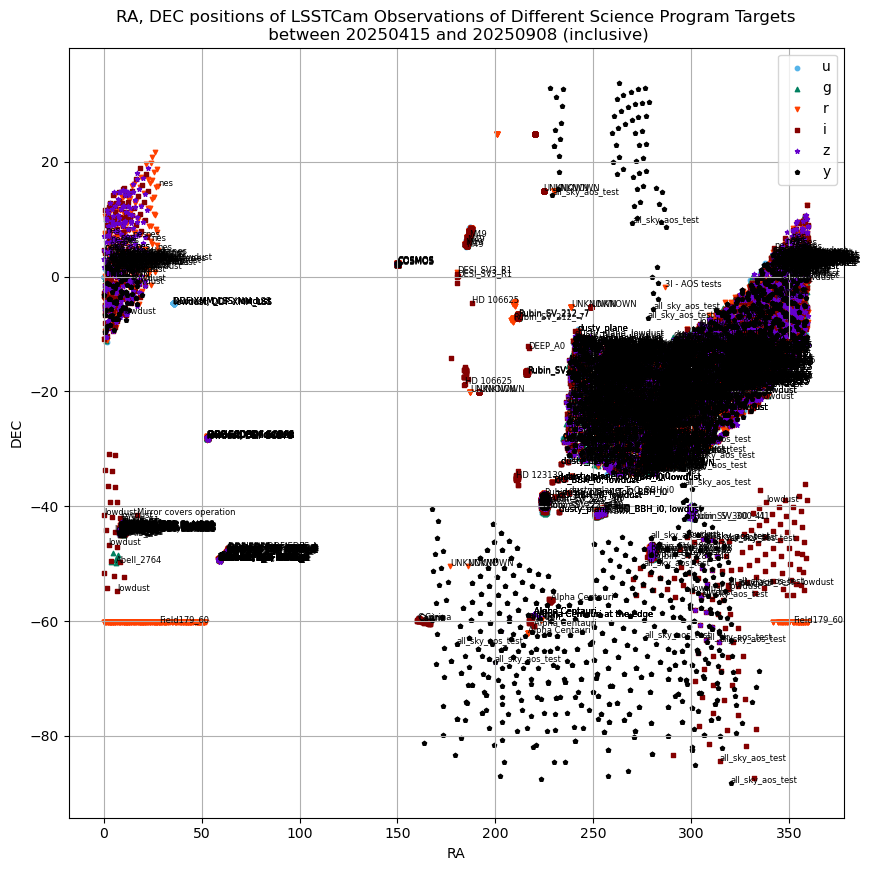

In [39]:
## 3.3 Positions

### 3.3.1 Target RA, DEC

df_sci.sort_values(by='field_name', inplace=True)

plt.figure(figsize=(10, 10))

# Extract base filter name (first character) from filter column
df_sci['base_filter'] = df_sci['filter'].str[0]

# Plot each filter separately to use different markers
for filter_name in plot_filter_labels:
    mask = df_sci['base_filter'] == filter_name
    if mask.any():  # Only plot if there are observations in this filter
        if df_sci[col_target].dtype == "int64" or df_sci[col_target].dtype == "float64":
            plt.scatter(df_sci[mask]['ra'], df_sci[mask]['dec'],
                       c=df_sci[mask][col_target],
                       marker=plot_filter_symbols[filter_name],
                       s=10,
                       label=filter_name)
        else:
            plt.scatter(df_sci[mask]['ra'], df_sci[mask]['dec'],
                       c=plot_filter_colors[filter_name],
                       marker=plot_filter_symbols[filter_name],
                       s=10,
                       label=filter_name)
            # Add annotations for non-numeric targets
            prev_label = 'XXXXXX'
            for i, label in enumerate(df_sci[mask][col_target]):
                if label != prev_label:
                    plt.annotate(label, 
                                (df_sci[mask]['ra'].iloc[i], df_sci[mask]['dec'].iloc[i]), 
                                fontsize=6)
                    prev_label = label

# Add labels and title
plt.xlabel('RA')
plt.ylabel('DEC')
title = """RA, DEC positions of %s Observations of Different Science Program Targets\n between %s and %s (inclusive)""" %(instrument, day_obs_start, day_obs_end)
plt.title(title)
plt.grid(True)
plt.legend()

## Science Target Exposure Zenith Angles

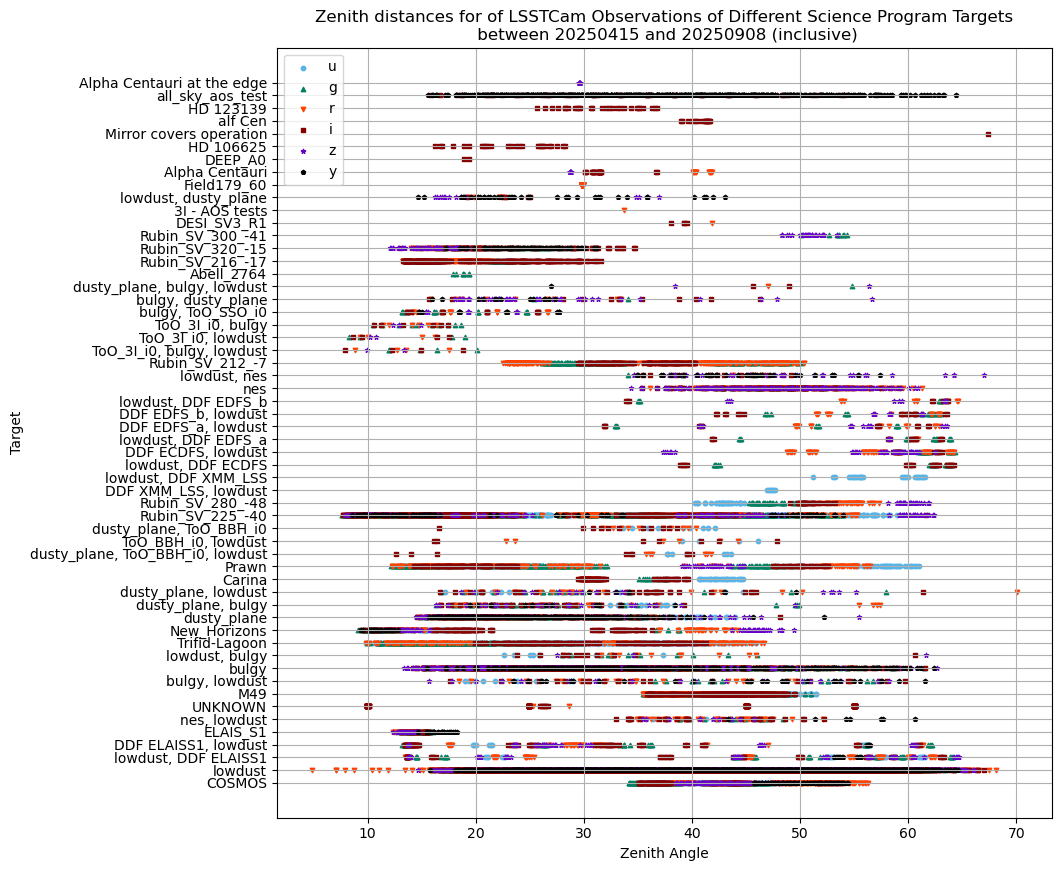

In [40]:
### 3.3.2 Target vs. zenith_angle

plt.figure(figsize=(10, 10))

# Extract base filter name (first character) from filter column
df_sci['base_filter'] = df_sci['filter'].str[0]

# Plot each filter separately to use different markers
for filter_name in plot_filter_labels:
    mask = df_sci['base_filter'] == filter_name
    if mask.any():  # Only plot if there are observations in this filter
        plt.scatter(df_sci[mask]['zenith_angle'], 
                   df_sci[mask][col_target],
                   c=plot_filter_colors[filter_name],
                   marker=plot_filter_symbols[filter_name],
                   s=10,
                   label=filter_name)

# Add labels and title
plt.xlabel('Zenith Angle')
plt.ylabel('Target')
title = """Zenith distances for of %s Observations of Different Science Program Targets\n between %s and %s (inclusive)""" %(instrument, day_obs_start, day_obs_end)
plt.title(title)
plt.grid(True)
plt.legend()

## Science Target Exposure MJDs

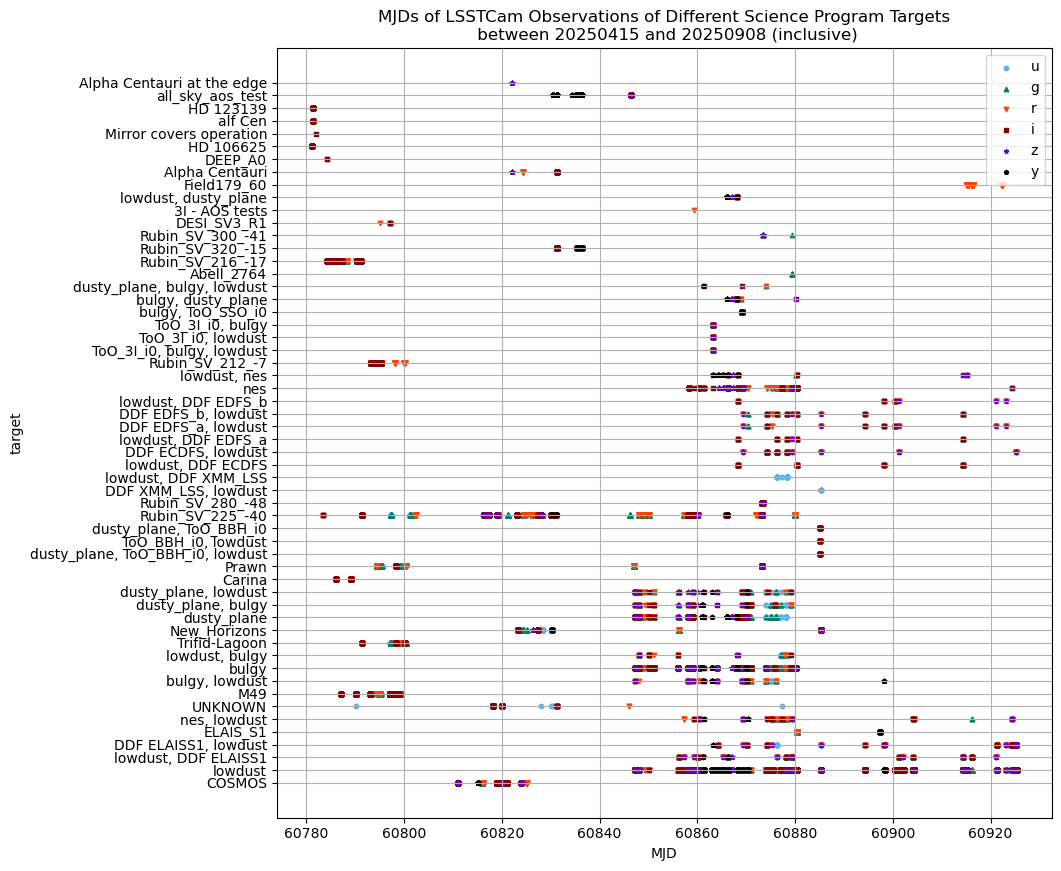

In [41]:
### 3.3.3 Target vs. MJD

plt.figure(figsize=(10, 10))

# Extract base filter name (first character) from filter column
df_sci['base_filter'] = df_sci['filter'].str[0]

# Plot each filter separately to use different markers
for filter_name in plot_filter_labels:
    mask = df_sci['base_filter'] == filter_name
    if mask.any():  # Only plot if there are observations in this filter
        plt.scatter(df_sci[mask]['mjd'], 
                   df_sci[mask][col_target],
                   c=plot_filter_colors[filter_name],
                   marker=plot_filter_symbols[filter_name],
                   s=10,
                   label=filter_name)

# Add labels and title
plt.xlabel('MJD')
plt.ylabel(col_target)
title = """MJDs of %s Observations of Different Science Program Targets\n between %s and %s (inclusive)""" %(instrument, day_obs_start, day_obs_end)
plt.title(title)
plt.grid(True)
plt.legend()

## Science Target Exposure Zenith Angles vs. MJD

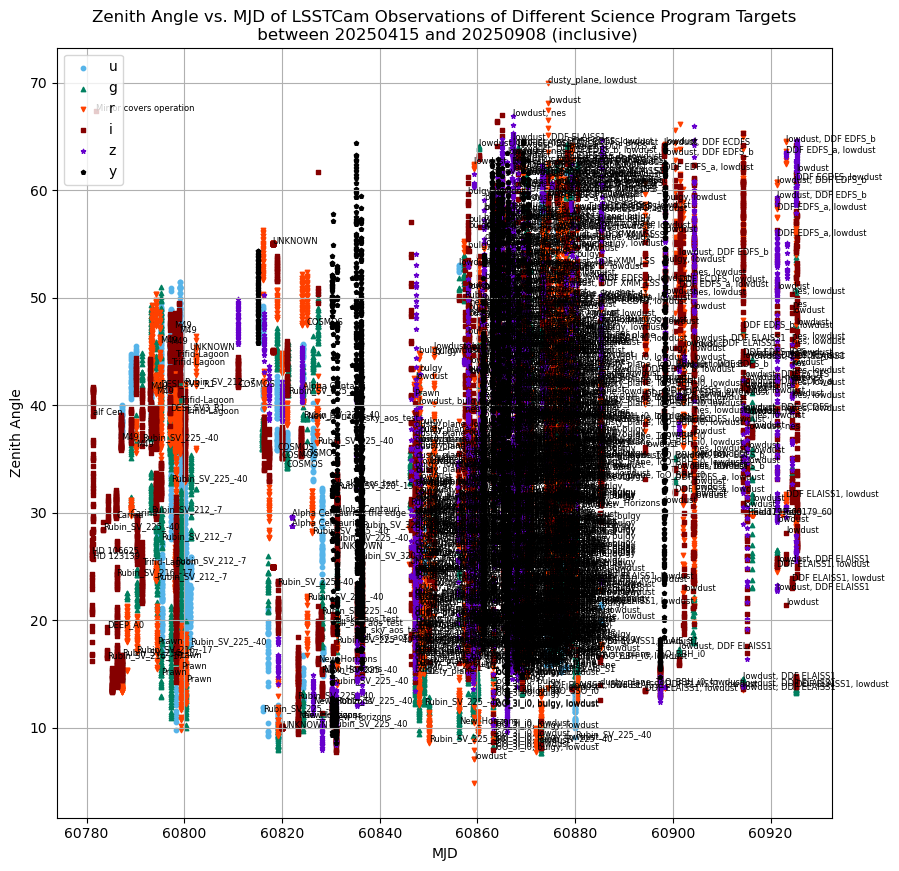

In [42]:
### 3.3.4 Target zenith angle vs. MJD

df_sci.sort_values(by='mjd', inplace=True)

plt.figure(figsize=(10, 10))

# Extract base filter name (first character) from filter column
df_sci['base_filter'] = df_sci['filter'].str[0]

# Plot in Cartesian coordinates
if df_sci[col_target].dtype == "int64" or df_sci[col_target].dtype == "float64":
    # For numerical targets, plot each filter with color based on target value
    for filter_name in plot_filter_labels:
        mask = df_sci['base_filter'] == filter_name
        if mask.any():  # Only plot if there are observations in this filter
            plt.scatter(df_sci[mask]['mjd'], 
                       df_sci[mask]['zenith_angle'],
                       c=df_sci[mask][col_target],
                       marker=plot_filter_symbols[filter_name],
                       s=10,
                       label=filter_name)
else:
    # For string targets, plot each filter with its designated color
    for filter_name in plot_filter_labels:
        mask = df_sci['base_filter'] == filter_name
        if mask.any():  # Only plot if there are observations in this filter
            plt.scatter(df_sci[mask]['mjd'], 
                       df_sci[mask]['zenith_angle'],
                       c=plot_filter_colors[filter_name],
                       marker=plot_filter_symbols[filter_name],
                       s=10,
                       label=filter_name)
    
    # Add annotations for non-numeric targets
    prev_label = 'XXXXXX'
    for i, label in enumerate(df_sci[col_target]):
        if label != prev_label:
            plt.annotate(label, 
                        (df_sci['mjd'].iloc[i], df_sci['zenith_angle'].iloc[i]), 
                        fontsize=6)
            prev_label = label

# Add labels and title
plt.xlabel('MJD')
plt.ylabel('Zenith Angle')
title = """Zenith Angle vs. MJD of %s Observations of Different Science Program Targets\n between %s and %s (inclusive)""" %(instrument, day_obs_start, day_obs_end)
plt.title(title)
plt.grid(True)
plt.legend()

In [43]:

# 4. Final cleanup

# Reset the display.max_rows option to the original default
pd.reset_option("display.max_rows")